# CLIPSeg

In [1]:
import os
import glob
import time
import csv
import torch
import numpy as np
from PIL import Image
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import matplotlib.pyplot as plt

In [16]:
# --- Setup ---
image_dir = r"Sample Images"
image_paths = glob.glob(os.path.join(image_dir, "*.png")) + \
              glob.glob(os.path.join(image_dir, "*.jpg")) + \
              glob.glob(os.path.join(image_dir, "*.jpeg"))

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load model ---
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)
model.eval()

# --- Prompt (you can modify this) ---
prompt = ["central bright laser spot"]

# --- Storage ---
timing_data = []
mask_results = []  # keep masks for optional plotting later

# --- Create output subfolder ---
output_dir = os.path.join(image_dir, "CLIPSeg_Masks")
os.makedirs(output_dir, exist_ok=True)

counter = 1
# --- Iterate through images ---
for img_path in image_paths:
    # if counter > 1: break # Uncomment to limit number of images processed for testing
    print(f"Processing {img_path}")
    counter = counter + 1

    # Load grayscale image and convert to RGB
    img_gray = Image.open(img_path).convert("L")
    img_rgb = Image.merge("RGB", (img_gray, img_gray, img_gray))

    # Process inputs
    inputs = processor(
        text=prompt,
        images=[img_rgb] * len(prompt),
        padding="max_length",
        return_tensors="pt"
    ).to(device)

    # Measure time
    start_time = time.time()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.time()

    # Compute inference time
    elapsed_time = end_time - start_time
    timing_data.append({"image": os.path.basename(img_path), "time_sec": elapsed_time})

    # Generate mask
    logits = outputs.logits.unsqueeze(1)  # shape: [B, 1, H, W]
    mask = torch.sigmoid(logits[0]).squeeze().cpu().numpy()
    mask_bin = (mask > 0.5).astype(np.uint8) * 255
    mask_img = Image.fromarray(mask_bin)
    
    mask_img = mask_img.resize(img_gray.size, resample=Image.BICUBIC)

    # Save mask to subfolder
    mask_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_CLIPSeg_{prompt[0].replace(' ', '_')}.png"
    mask_img.save(os.path.join(output_dir, mask_name))

    mask_results.append((os.path.basename(img_path), img_gray, mask_img))

# --- Save timing results ---
csv_path = os.path.join(output_dir, "segmentation_times_CLIPSeg.csv")
with open(csv_path, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["image", "time_sec"])
    writer.writeheader()
    writer.writerows(timing_data)

print(f"Timing results saved to {csv_path}")

Processing Sample Images\Image 1.png
Processing Sample Images\Image 2.png
Processing Sample Images\Image 3.png
Processing Sample Images\Image 4.png
Processing Sample Images\Image 5.png
Timing results saved to Sample Images\CLIPSeg_Masks\segmentation_times_CLIPSeg.csv


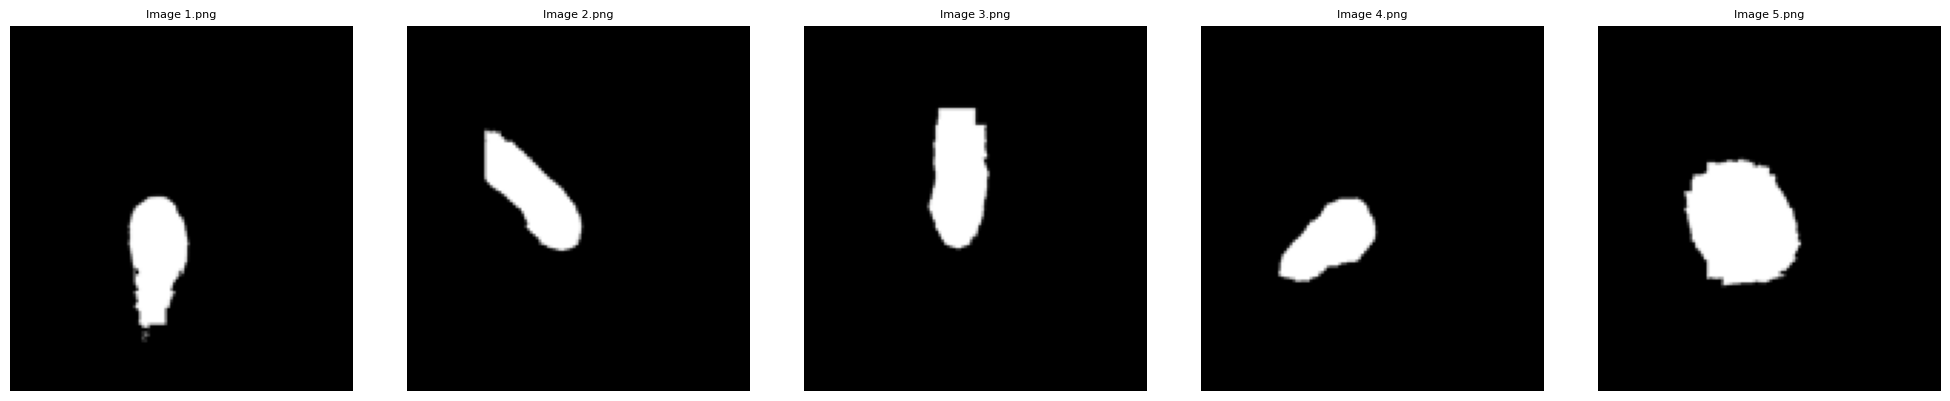

In [17]:
# --- Optional Plotting ---
n_cols = 5
n_images = len(mask_results)
n_rows = (n_images + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, (img_name, img_gray, mask_img) in zip(axes, mask_results):
    ax.imshow(mask_img, cmap="gray")
    ax.set_title(img_name, fontsize=8)
    ax.axis("off")    

# Hide unused axes if any
for ax in axes[len(mask_results):]:
    ax.axis("off")

plt.tight_layout()
plt.show()